In [1]:
import os
import re
import numpy as np
import pandas as pd

def parse_logs(folder_path):
    """
    Parse all .log files in the given folder and return a DataFrame with columns
    ['logname', 'epoch', 'train_loss', 'val_loss', 'avg_peak_prob'].
    """
    # regex patterns
    epoch_re       = re.compile(r"Epoch\s+(\d+)\/")
    train_loss_re  = re.compile(r"train loss:\s*([0-9]*\.?[0-9]+)", re.IGNORECASE)
    val_loss_re    = re.compile(r"val loss:\s*([0-9]*\.?[0-9]+)",   re.IGNORECASE)
    avg_peak_re    = re.compile(r"\*avg peak prob:\s*([0-9]*\.?[0-9]+)", re.IGNORECASE)

    records = []

    for fname in os.listdir(folder_path):
        if not fname.endswith(".log"):
            continue
        fullpath = os.path.join(folder_path, fname)
        with open(fullpath, "r") as f:
            current_epoch    = None
            train_loss       = np.nan
            val_loss         = np.nan
            avg_peak_probs   = []

            for line in f:
                # start of a new epoch
                m = epoch_re.search(line)
                if m:
                    # if we have data from a previous epoch, record it
                    if current_epoch is not None:
                        records.append({
                            "logname":        fname,
                            "epoch":          current_epoch,
                            "train_loss":     train_loss,
                            "val_loss":       val_loss,
                            "avg_peak_prob":  np.nanmean(avg_peak_probs) if avg_peak_probs else np.nan
                        })
                    # reset for the new epoch
                    current_epoch  = int(m.group(1))
                    train_loss     = np.nan
                    val_loss       = np.nan
                    avg_peak_probs = []
                    continue

                # train loss
                m = train_loss_re.search(line)
                if m and current_epoch is not None:
                    train_loss = float(m.group(1))
                    continue

                # validation loss
                m = val_loss_re.search(line)
                if m and current_epoch is not None:
                    val_loss = float(m.group(1))
                    continue

                # avg peak prob
                m = avg_peak_re.search(line)
                if m and current_epoch is not None:
                    avg_peak_probs.append(float(m.group(1)))
                    continue

            # after finishing the file, record the last epoch if any
            if current_epoch is not None:
                records.append({
                    "logname":        fname,
                    "epoch":          current_epoch,
                    "train_loss":     train_loss,
                    "val_loss":       val_loss,
                    "avg_peak_prob":  np.nanmean(avg_peak_probs) if avg_peak_probs else np.nan
                })

    # build DataFrame
    df = pd.DataFrame.from_records(records,
        columns=["logname", "epoch", "train_loss", "val_loss", "avg_peak_prob"])
    return df

# Example usage:
df = parse_logs("logs/important-runs")
print(df.head())


                          logname  epoch  train_loss  val_loss  avg_peak_prob
0  2513_heatmap_lowres_bignet.log      1      0.7819    0.7391            NaN
1  2513_heatmap_lowres_bignet.log      2      0.7577    0.7539            NaN
2  2513_heatmap_lowres_bignet.log      3      0.7569    0.7381            NaN
3  2513_heatmap_lowres_bignet.log      4      0.7610    0.7031            NaN
4  2513_heatmap_lowres_bignet.log      5      0.7228    0.6811            NaN


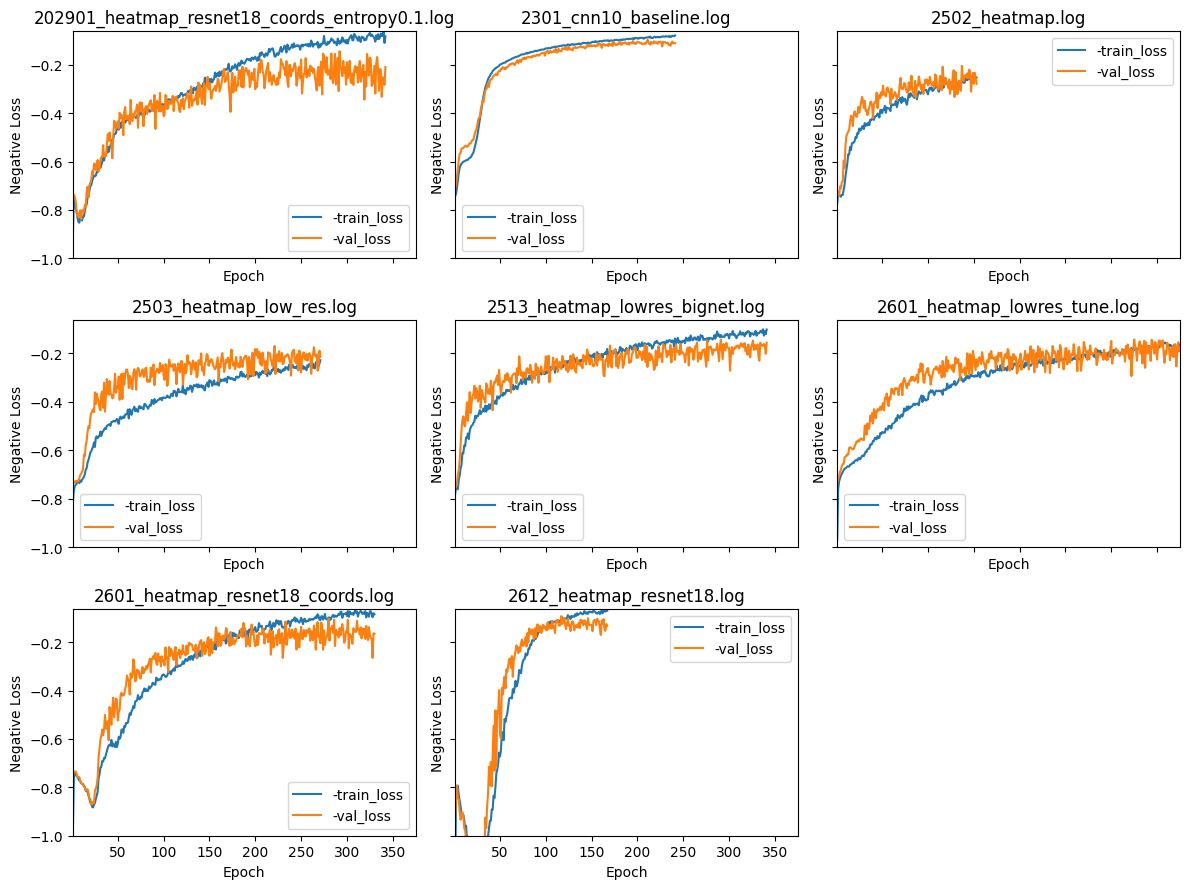

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_losses(df):
    # Determine unique log files and grid size
    lognames = sorted(df['logname'].unique())
    n = len(lognames)
    n_cols = int(np.ceil(np.sqrt(n)))
    n_rows = int(np.ceil(n / n_cols))

    # Global x and y limits
    max_epoch = int(df['epoch'].max())
    neg_train = -df['train_loss']
    neg_val   = -df['val_loss']
    y_min = float(min(neg_train.min(), neg_val.min()))
    y_max = float(max(neg_train.max(), neg_val.max()))

    # Create subplots grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, log in zip(axes, lognames):
        sub = df[df['logname'] == log]
        ax.plot(sub['epoch'], -sub['train_loss'], label='-train_loss')
        ax.plot(sub['epoch'], -sub['val_loss'],   label='-val_loss')
        ax.set_title(log)
        ax.set_xlim(1, max_epoch)
        ax.set_ylim(-1.0, y_max)# y_min, y_max)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Negative Loss')
        ax.legend()

    # Turn off any unused axes
    for ax in axes[len(lognames):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_losses(df)
